In [ ]:
#1
import numpy as np 
import pandas as pd 
import pandas_datareader as pdr
import pandas_datareader as web
from datetime import date 
import datetime as dt
from matplotlib import pyplot 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns
from numpy import concatenate
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import array as arr


py.init_notebook_mode(connected=True)
%matplotlib inline

In [ ]:
#2.Visualising the data set using pandas datareader
data=pd.read_csv('bit_proj.csv')

In [ ]:
#3.Visualising the features of dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1621 entries, 0 to 1620
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1621 non-null   object 
 1   Open       1621 non-null   float64
 2   High       1621 non-null   float64
 3   Low        1621 non-null   float64
 4   Close      1621 non-null   float64
 5   Adj Close  1621 non-null   float64
 6   Volume     1621 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 88.8+ KB


In [ ]:
#4.Displaying the open,close, high, low price of the nifty50 stocks from the dataset
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-10-20,5708.109863,6060.109863,5627.229980,6011.450195,6011.450195,2354429952
1,2017-10-21,5996.790039,6194.879883,5965.069824,6031.600098,6031.600098,2207099904
2,2017-10-22,6036.660156,6076.259766,5792.339844,6008.419922,6008.419922,2034630016
3,2017-10-23,6006.000000,6075.589844,5732.470215,5930.319824,5930.319824,2401840128
4,2017-10-24,5935.520020,5935.520020,5504.180176,5526.640137,5526.640137,2735699968


In [ ]:
data.to_csv('nifty3.csv')

In [ ]:
#5.Plotting the graph for timeline vs adjacent close price for the whole gathered data
btc_trace = go.Scatter(x=data.index, y=data['Adj Close'],name='price')
py.iplot([btc_trace])

In [ ]:
#6. Normalising the adjacent close price data
data['Adj Close'].replace(0, np.nan, inplace=True)
data['Adj Close'].fillna (method ='ffill', inplace=True)

In [ ]:
#7. Replotting the graph after normalisation
btc_trace = go.Scatter(x=data.index, y=data['Adj Close'],name='price')
py.iplot([btc_trace])

In [ ]:
#8. Now, using MinMaxScaler function we perform scaling, preprocessing (Normalisation) of the dataset features.
from sklearn.preprocessing import MinMaxScaler
values = data['Adj Close'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

In [ ]:
#9. Here, we assign and calculate the size and shape of training data and testing dataset(70% for training data and rest for validation and testing purpose)
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))
train.shape


1134 487


(1134, 1)

In [ ]:
#10. We divide the total dataset into two major parts, where each part contains its own data features,namely X and Y
#and assign an array to both the parts using numpy.
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
    
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)    

In [ ]:
#11. Now we divide the respective X and Y features each for training and testing. 
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

1133
486


In [ ]:
#12. Here We needed to reshape the X feature of training and testing data before processing it.
trainX = np.reshape(trainX, (trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0],1,testX.shape[1]))

In [ ]:
#13.We perform training and validation of the dataset using LSTM sequential model ,adam optimizer and Mean absolute error loss funtion
model=Sequential()
model.add(LSTM(100,activation='sigmoid',input_shape=(trainX.shape[1],trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae',optimizer='adam')
history=model.fit(trainX,trainY,epochs=300,batch_size=100,validation_data=(testX,testY),verbose=0,shuffle=False)

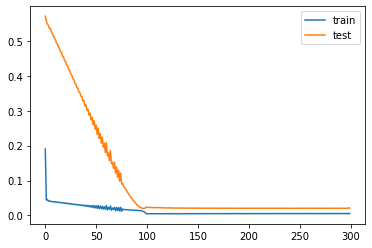

In [ ]:
#14.Here, we plot the 'epoch' vs 'loss' graph for the training(blue mark) and testing(orange) dataset respectively.
pyplot.plot(history.history['loss'],label='train')
pyplot.plot(history.history['val_loss'],label='test')
pyplot.legend()
pyplot.show()

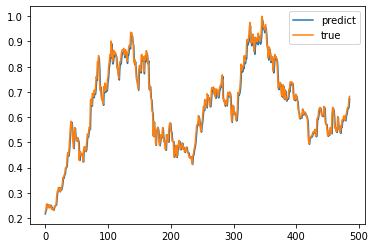

In [ ]:
#15.Now we plot a graph for comparing the predicted price(marked in blue) vs the actual prize(marked in orange) for the test data
yhat = model.predict(testX)
pyplot.plot(yhat,label='predict')
pyplot.plot(testY,label='true')
pyplot.legend()
pyplot.show()


In [ ]:
#16.Here we perform normalisation of the Y feature of test data using the inverse transform function
yhat_inverse=scaler.inverse_transform(yhat.reshape(-1,1))
testY_inverse=scaler.inverse_transform(testY.reshape(-1,1))

In [ ]:
#17.We calculate the root mean square error of the test data)
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1794.134


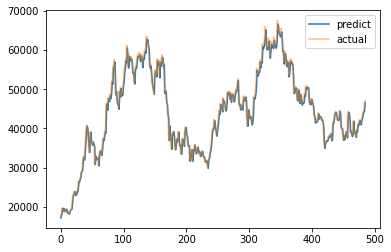

In [ ]:
#18. After normalisation, we again plot a graph for comparing the predicted price(marked in blue) vs the actual prize(marked in orange) with timeline for the test data
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [ ]:
predictDates =data.tail(len(testX)).index

In [ ]:
#19.Final data Normalisation
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [ ]:
#20. Here is the final graph plotted for comparing the actual stock price and the predicted stock price with respect to the timeline 
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([actual_chart,predict_chart])

In [ ]:
#21. Here we repeat the steps (from #21 to #31) same as performed above for multi-training, validating and multi-testing of the predicted dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars=1 if type(data) is list else data.shape[1] 
  df=pd.DataFrame(data)
  cols, names = list(), list()
  #input sequence (t-n,...t-1)
  for i in range(n_in,0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]
  #forecast sequence
  for i in range(0,n_out):
    cols.append(df.shift(-i))
    if i==0:
       names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
       names += [('var%d(t+%d)' % (j+1,i)) for j in range(n_vars)]
  # put it all together
  agg=pd.concat(cols, axis=1)
  agg.columns = names
  #drop rows with NaN values
  if dropnan:
      agg.dropna(inplace=True)
  return agg  

In [ ]:
#22.
values = data[['Adj Close']+['Volume']].values
values = values.astype('float32')

In [ ]:
#23.
scaler=MinMaxScaler(feature_range=(0,1))
scaled=scaler.fit_transform(values)

In [ ]:
#24.
reframed = series_to_supervised (scaled,1,1)
reframed.head()

,var1(t-1),var2(t-1),var1(t),var2(t)
1,0.043132,0.002719,0.043445,0.002298
2,0.043445,0.002298,0.043085,0.001804
3,0.043085,0.001804,0.041871,0.002855
4,0.041871,0.002855,0.035596,0.003810
5,0.035596,0.003810,0.039080,0.001611


In [ ]:
#25.
reframed.drop(reframed.columns[[3]],axis=1,inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)   var1(t)
1   0.043132   0.002719  0.043445
2   0.043445   0.002298  0.043085
3   0.043085   0.001804  0.041871
4   0.041871   0.002855  0.035596
5   0.035596   0.003810  0.039080


In [ ]:
#26.
values=reframed.values
n_train_hours = int(len(values)*0.7)
train=values[:n_train_hours,:]
test=values[n_train_hours:,:]
# split into inputs and outputs
train_X, train_y = train[:,:-1], train[:,-1]
test_X, test_y = test[:,:-1], test[:,-1] 
#reshape input to be 3D
train_X=train_X.reshape((train_X.shape[0],1,train_X.shape[1]))
test_X=test_X.reshape((test_X.shape[0],1,test_X.shape[1]))
print(train_X.shape,train_y.shape,test_X.shape,test_y.shape)

(1134, 1, 2) (1134,) (486, 1, 2) (486,)


In [ ]:
#27.
multi_model=Sequential()
multi_model.add(LSTM(100,activation='sigmoid', input_shape=(train_X.shape[1],train_X.shape[2])))
multi_model.add(Dense(1))
multi_model.compile(loss='mae',optimizer='adam')
multi_history=multi_model.fit(train_X,train_y,epochs=300,batch_size=100,validation_data=(test_X,test_y),verbose=0,shuffle=False)

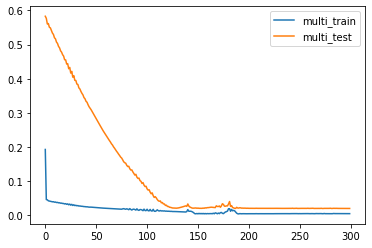

In [ ]:
#28.
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

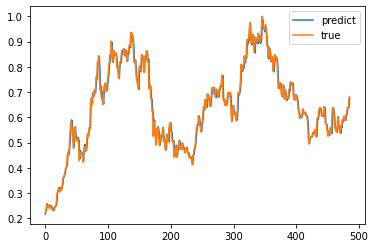

In [ ]:
#29.
yhat = multi_model.predict(test_X)
pyplot.plot(yhat,label='predict')
pyplot.plot(test_y,label='true')
pyplot.legend()
pyplot.show()

In [ ]:
#29.
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))
#invert scaling for forecast
inv_yhat = concatenate((yhat,test_X[:,1:]),axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
#invert scaling for actual
test_y = test_y.reshape((len(test_y),1))
inv_y = concatenate((test_y,test_X[:,1:]),axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y =inv_y [:,0]

In [ ]:
#30.
rmse=sqrt(mean_squared_error(inv_y,inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1764.484


In [ ]:
#31.
actual_chart=go.Scatter(x=predictDates,y=inv_y,name='Actual Price')
multi_predict_chart = go.Scatter(x=predictDates,y=inv_yhat,name='Multi Predict Price')
predict_chart=go.Scatter(x=predictDates,y=yhat_reshape, name='Predict Price')
py.iplot([actual_chart,multi_predict_chart,predict_chart])

In [ ]:
#32.Here is the Program for predicting the next day future price of the nifty50 stock which is predicted by using minmaxscaler function over the dataset
prediction_days = 2
test_data = pd.read_csv('nifty3.csv')
total_dataset = pd.concat((data['Close'],test_data['Close']),axis=0)
model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
min_max_scaler = MinMaxScaler(feature_range=(0,1))
model_inputs = min_max_scaler.fit_transform(model_inputs) 
real_data = [model_inputs[len(model_inputs)+1-prediction_days:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data,(real_data.shape[0],real_data.shape[1],1))
prediction = model.predict(real_data)
prediction = min_max_scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")


Prediction: [[46818.56]]
